In [1]:
# Impotación de las librerías
import pandas as pd
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import gc
import kagglehub
import os
import zipfile
from PIL import Image
from tqdm import tqdm
import seaborn as sns

d:\Utec 2025-2\Machine\P2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# CARGA DE DATOS
path_movies_train = "../data/movies_train.csv"
path_movies = "../data/movies.csv"
path_links = "../data/links.csv"
path_tags = "../data/tags.csv"
path_genome_tags = "../data/genome-tags.csv"
path_genome_scores = "../data/genome-scores.csv"
path_ratings = "../data/ratings.csv"

movies_train = pl.read_csv(path_movies_train)
movies = pl.read_csv(path_movies)
links = pl.read_csv(path_links)
tags = pl.read_csv(path_tags)
genome_tags = pl.read_csv(path_genome_tags)
genome_scores = pl.read_csv(path_genome_scores)
ratings = pl.read_csv(path_ratings)

Agregando la carga de datos del kagglehub

In [16]:
path = kagglehub.dataset_download("neha1703/movie-genre-from-its-poster")
print("Path to dataset files:", path)

100%|██████████| 35.9M/35.9M [00:00<00:00, 52.8MB/s]Extracting files...

Path to dataset files: /root/.cache/kagglehub/datasets/neha1703/movie-genre-from-its-poster/versions/5


In [19]:
base_path = path

# Listar contenido descargado
print("Contenido descargado:")
print(os.listdir(base_path))

# Descomprimir los ZIPs
for fname in ["train.zip", "test.zip"]:
    zpath = os.path.join(base_path, fname)
    if os.path.exists(zpath):
        print(f"Descomprimiendo {fname}...")
        with zipfile.ZipFile(zpath, 'r') as zf:
            zf.extractall(os.path.join(base_path, fname.replace(".zip","")))
print("Dataset descomprimido.")

Contenido descargado:
['MovieGenre.csv', 'SampleMoviePosters', 'samplemovieposters']
Dataset descomprimido.


In [22]:
base_path = path
print("Archivos en la carpeta base:", os.listdir(base_path))
print("\nEjemplo dentro de samplemovieposters/:", os.listdir(os.path.join(base_path, "samplemovieposters"))[:10])

Archivos en la carpeta base: ['MovieGenre.csv', 'SampleMoviePosters', 'samplemovieposters']

Ejemplo dentro de samplemovieposters/: ['SampleMoviePosters']


In [25]:
# Ruta base del dataset
base_path = path

# Ruta donde deberían estar las imágenes
img_dir = os.path.join(base_path, "samplemovieposters", "SampleMoviePosters")

print("Ruta esperada de imágenes:", img_dir)
print("Existe carpeta:", os.path.exists(img_dir))
print("Cantidad de archivos:", len(os.listdir(img_dir)) if os.path.exists(img_dir) else 0)
print("Ejemplo de archivos:", os.listdir(img_dir)[:10] if os.path.exists(img_dir) else [])

Ruta esperada de imágenes: /root/.cache/kagglehub/datasets/neha1703/movie-genre-from-its-poster/versions/5/samplemovieposters/SampleMoviePosters
Existe carpeta: True
Cantidad de archivos: 997
Ejemplo de archivos: ['10040.jpg', '10057.jpg', '10071.jpg', '10155.jpg', '10195.jpg', '10208.jpg', '10247.jpg', '10267.jpg', '10281.jpg', '10307.jpg']


In [28]:
IMG_DIR = "/root/.cache/kagglehub/datasets/neha1703/movie-genre-from-its-poster/versions/5/samplemovieposters/SampleMoviePosters"
CSV_PATH = "/root/.cache/kagglehub/datasets/neha1703/movie-genre-from-its-poster/versions/5/MovieGenre.csv"

EDA sin imágenes

In [31]:
print("links:\n", links.head())
print("movies:\n", movies.head())
print("ratings:\n", ratings.head())
print("tags:\n", tags.head())
print("genome_scores:\n", genome_scores.head())
print("genome_tags:\n", genome_tags.head())
print("movies_train:\n", movies_train.head())


links:
 shape: (5, 3)
┌─────────┬────────┬────────┐
│ movieId ┆ imdbId ┆ tmdbId │
│ ---     ┆ ---    ┆ ---    │
│ i64     ┆ i64    ┆ i64    │
╞═════════╪════════╪════════╡
│ 1       ┆ 114709 ┆ 862    │
│ 2       ┆ 113497 ┆ 8844   │
│ 3       ┆ 113228 ┆ 15602  │
│ 4       ┆ 114885 ┆ 31357  │
│ 5       ┆ 113041 ┆ 11862  │
└─────────┴────────┴────────┘
movies:
 shape: (5, 3)
┌─────────┬─────────────────────────────────┬─────────────────────────────────┐
│ movieId ┆ title                           ┆ genres                          │
│ ---     ┆ ---                             ┆ ---                             │
│ i64     ┆ str                             ┆ str                             │
╞═════════╪═════════════════════════════════╪═════════════════════════════════╡
│ 1       ┆ Toy Story (1995)                ┆ Adventure|Animation|Children|C… │
│ 2       ┆ Jumanji (1995)                  ┆ Adventure|Children|Fantasy      │
│ 3       ┆ Grumpier Old Men (1995)         ┆ Comedy|Romance     

### LINKS
Claves númericas limpias. Validaremos la unicidad de movieID y imbdId

### MOVIES

Estructura clásica: movie, title (incluye año), genres string separado.
Podemos extraer años y géneros base.

### RATINGS

Campos típicos (userId, movieId, rating, timestamp). Podemos medir la popularidad, validar los vecinos con buen rating

### TAGS, GENOME_TAGS, GENOME_SCORES

Tags: etiquetas libres por usuarios, puede ser ruidosa.

genome_tags + genome_scores: ontología de tags con relevancias similares por movieId. 
Chequear vecinos comparten semántica.

Arman una nube de palabras sin imágenes

### MOVIES_TRAIN
Tiene movieId, title, genres y one-hots por género como Sci-Fi, Thiller, Western.

Objetivo operativo del challenge, películas a evaluar. Si nuestros vecinos son coherentes.
Cruzar con links para estimar cobertura de pósters específicamente en train.

In [40]:
print("Tamaños:")
print(f"- movies_train: {movies_train.height} x {movies_train.width}")
print(f"- movies       : {movies.height} x {movies.width}")
print(f"- links        : {links.height} x {links.width}")
print(f"- ratings      : {ratings.height} x {ratings.width}")
print(f"- tags         : {tags.height} x {tags.width}")
print(f"- genome_tags  : {genome_tags.height} x {genome_tags.width}")
print(f"- genome_scores: {genome_scores.height} x {genome_scores.width}")

#Unicidad de claves
nunique_movies = movies.select(pl.col("movieId").n_unique()).item()
dup_movies = movies.height - nunique_movies

nunique_links = links.select(pl.col("movieId").n_unique()).item()
dup_links = links.height - nunique_links

print("\nUnicidad de claves:")
print(f"- movies.movieId únicos: {nunique_movies}  (duplicados = {dup_movies})")
print(f"- links.movieId  únicos: {nunique_links}  (duplicados = {dup_links})")

# Nulos críticos
null_imdb_in_links = links.select(pl.col("imdbId").is_null().sum().alias("null_imdb")).item()
print("\nNulos críticos:")
print(f"- links.imdbId nulos: {null_imdb_in_links}")

# Cardinalidad del join (movies_train ⟂ links) 
train_links = movies_train.join(links, on="movieId", how="left")

# ¿Se duplicaron filas del lado train?
dup_after_join = (
    train_links
    .group_by("movieId")
    .agg(pl.len().alias("rows"))
    .filter(pl.col("rows") > 1)
    .height
)
print("\nCardinalidad del join (movies_train ⋈ links):")
print(f"- Filas en movies_train: {movies_train.height}")
print(f"- Filas en train⋈links: {train_links.height}")
print(f"- movieId con duplicación tras join (>1 fila): {dup_after_join}")

# Cobertura teórica de pósters en TRAIN (por imdbId no nulo) 
train_with_imdb = train_links.filter(pl.col("imdbId").is_not_null()).height
coverage_train = train_with_imdb / movies_train.height if movies_train.height else 0.0
print("\nCobertura teórica de pósters en TRAIN (vía imdbId):")
print(f"- Con imdbId: {train_with_imdb}/{movies_train.height}  -> coverage = {coverage_train:.3%}")

#  Ratings: cobertura y rangos 
# Cobertura: ¿cuántas pelis de train tienen ≥1 rating?
ratings_by_movie = ratings.group_by("movieId").agg(
    pl.len().alias("n_ratings"),
    pl.col("rating").mean().alias("rating_mean")
)
train_ratings = movies_train.join(ratings_by_movie, on="movieId", how="left")
movies_with_ratings = train_ratings.select(pl.col("n_ratings").fill_null(0) > 0).sum().item()
coverage_ratings_train = movies_with_ratings / movies_train.height if movies_train.height else 0.0

# Rango de ratings y rango temporal
rating_range = ratings.select(
    pl.col("rating").min().alias("min_rating"),
    pl.col("rating").max().alias("max_rating")
).to_dicts()[0]

ts_range = ratings.select(
    ((pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).min()).alias("min_ts"),
    ((pl.col("timestamp") * 1000).cast(pl.Datetime("ms")).max()).alias("max_ts")
).to_dicts()[0]

print("\nRatings (sanidad y cobertura en TRAIN):")
print(f"- Películas de train con ≥1 rating: {movies_with_ratings}/{movies_train.height} -> {coverage_ratings_train:.3%}")
print(f"- Rango de rating observado: [{rating_range['min_rating']}, {rating_range['max_rating']}]")
print(f"- Rango de timestamps (UTC aproximado): {ts_range['min_ts']}  →  {ts_range['max_ts']}")

#  Cobertura de GENOME (semántica) en TRAIN 
# ¿Cuántas pelis de train tienen al menos una fila en genome_scores?
train_in_genome = (
    movies_train["movieId"]
    .is_in(genome_scores["movieId"])
    .sum()
)
coverage_genome_train = train_in_genome / movies_train.height if movies_train.height else 0.0
print("\nCobertura semántica (genome_scores) en TRAIN:")
print(f"- Con genome_scores: {train_in_genome}/{movies_train.height} -> {coverage_genome_train:.3%}")

#  Distribución de géneros (one-hot) en TRAIN
onehot_cols = [c for c in movies_train.columns if c not in ["movieId", "title", "genres"]]
genre_counts = movies_train.select([pl.col(c).sum().alias(c) for c in onehot_cols])

print("\nDistribución de géneros (one-hot) en TRAIN (top 10 por conteo):")
genre_counts_melt = genre_counts.melt(variable_name="genre", value_name="count").sort("count", descending=True)
print(genre_counts_melt.head(10))

# Año y década en TRAIN
movies_train_years = (
    movies_train
    .with_columns(
        pl.col("title").str.extract(r"\((\d{4})\)", 1).cast(pl.Int32).alias("year")
    )
    .with_columns(
        ((pl.col("year") // 10) * 10).alias("decade")
    )
)

decade_counts = (
    movies_train_years
    .group_by("decade")
    .agg(pl.len().alias("n_movies"))
    .sort("decade")
)

n_missing_year = movies_train_years.filter(pl.col("year").is_null()).height

print("\nAño y década en TRAIN:")
print(f"- Películas sin año detectable en title: {n_missing_year}")
print("Distribución por década:")
print(decade_counts)

#  Resumen ejecutivo
summary = {
    "train_rows": movies_train.height,
    "movies_rows": movies.height,
    "links_rows": links.height,
    "dup_movies_ids_in_movies": int(dup_movies),
    "dup_movie_ids_in_links": int(dup_links),
    "null_imdb_in_links": int(null_imdb_in_links),
    "train_with_imdbId": int(train_with_imdb),
    "coverage_train_imdbId_pct": round(coverage_train * 100, 2),
    "train_with_≥1_rating": int(movies_with_ratings),
    "coverage_train_ratings_pct": round(coverage_ratings_train * 100, 2),
    "train_with_genome": int(train_in_genome),
    "coverage_train_genome_pct": round(coverage_genome_train * 100, 2),
    "rating_min": float(rating_range["min_rating"]),
    "rating_max": float(rating_range["max_rating"]),
    "timestamp_min": str(ts_range["min_ts"]),
    "timestamp_max": str(ts_range["max_ts"]),
    "missing_year_in_train": int(n_missing_year),
}
print("\n RESUMEN")
for k, v in summary.items():
    print(f"{k}: {v}")

Tamaños:
- movies_train: 6819 x 23
- movies       : 62423 x 3
- links        : 62423 x 3
- ratings      : 25000095 x 4
- tags         : 1093360 x 4
- genome_tags  : 1128 x 2
- genome_scores: 15584448 x 3

Unicidad de claves:
- movies.movieId únicos: 62423  (duplicados = 0)
- links.movieId  únicos: 62423  (duplicados = 0)

Nulos críticos:
- links.imdbId nulos: 0

Cardinalidad del join (movies_train ⋈ links):
- Filas en movies_train: 6819
- Filas en train⋈links: 6819
- movieId con duplicación tras join (>1 fila): 0

Cobertura teórica de pósters en TRAIN (vía imdbId):
- Con imdbId: 6619/6819  -> coverage = 97.067%

Ratings (sanidad y cobertura en TRAIN):
- Películas de train con ≥1 rating: 6618/6819 -> 97.052%
- Rango de rating observado: [0.5, 5.0]
- Rango de timestamps (UTC aproximado): 1995-01-09 11:46:49  →  2019-11-21 09:15:03

Cobertura semántica (genome_scores) en TRAIN:
- Con genome_scores: 6060/6819 -> 88.869%

Distribución de géneros (one-hot) en TRAIN (top 10 por conteo):
shape

Sin duplicados en movies.movieId y links.movieId
0 nulos en imdbId (links)
Pósters teóricos en train: 6 619 / 6 819 → 97.07%
~200 películas de train sin imdbId empatable
Ratings en train: 6 618 / 6 819 → 97.05%.
Tienes señal de popularidad casi para todo train → buen fallback cuando falte vecino visual.
Genome (semántica): 6 060 / 6 819 → 88.87%.
Muy útil para validar coherencia de tus vecinos/clusteres sin ver imágenes

Rango y temporalidad

Ratings en [0.5, 5.0] (esperado en MovieLens).

Timestamps 1995–2019 → consistente con 25M; útil si luego quieres un corte temporal o analizar “modas” de diseño por época.

Desbalance fuerte: Drama (3 058) y Comedy (2 659) dominan.
Implicación: en clustering / evaluación de vecinos, estas clases tenderán a “dominar” y las métricas que miren coherencia por género serán más estables para géneros grandes y más ruidosas en géneros chicos.

12 títulos sin año (mínimo, aceptable).
Mayor masa en 2000s (2 018) y 2010s (1 355), seguido de 1990s (1 514) → justo las décadas donde el estilo de póster se diversifica; esto es buenísimo para encontrar familias visuales.

In [43]:
# GRANDES: usar Lazy (no se cargan a RAM hasta .collect())
tags_lf = pl.scan_csv(
    path_tags,
    dtypes={"userId": pl.Int64, "movieId": pl.Int64, "tag": pl.Utf8, "timestamp": pl.Int64},
)
genome_scores_lf = pl.scan_csv(
    path_genome_scores,
    dtypes={"movieId": pl.Int64, "tagId": pl.Int64, "relevance": pl.Float64},
)
ratings_lf = pl.scan_csv(
    path_ratings,
    dtypes={"userId": pl.Int64, "movieId": pl.Int64, "rating": pl.Float64, "timestamp": pl.Int64},
)

/tmp/ipykernel_44/3496623173.py:2: DeprecationWarning: the argument `dtypes` for `scan_csv` is deprecated. It was renamed to `schema_overrides` in version 0.20.31.
  tags_lf = pl.scan_csv(
/tmp/ipykernel_44/3496623173.py:6: DeprecationWarning: the argument `dtypes` for `scan_csv` is deprecated. It was renamed to `schema_overrides` in version 0.20.31.
  genome_scores_lf = pl.scan_csv(
/tmp/ipykernel_44/3496623173.py:10: DeprecationWarning: the argument `dtypes` for `scan_csv` is deprecated. It was renamed to `schema_overrides` in version 0.20.31.
  ratings_lf = pl.scan_csv(


In [25]:
def bar_plot(x, y, title, xlab, ylab, rot=45, w=12, h=4):
    plt.figure(figsize=(w, h)); plt.bar(x, y, alpha=0.85)
    plt.xticks(rotation=rot, ha='right'); plt.title(title)
    plt.xlabel(xlab); plt.ylabel(ylab); plt.grid(axis='y', alpha=0.25)
    plt.tight_layout(); plt.show(); plt.close()

def hist_from_counts(bin_edges, counts, title, xlab, w=10, h=4):
    centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
    plt.figure(figsize=(w, h))
    plt.bar(centers, counts, width=np.diff(bin_edges), align='center', alpha=0.85)
    plt.title(title); plt.xlabel(xlab); plt.ylabel("Frecuencia")
    plt.grid(axis='y', alpha=0.25); plt.tight_layout(); plt.show(); plt.close()

#  1) movies_train: géneros y cobertura 
KNOWN_GENRES = ["Action","Adventure","Animation","Children","Comedy","Crime","Documentary",
                "Drama","Fantasy","Film-Noir","Horror","IMAX","Musical","Mystery",
                "Romance","Sci-Fi","Thriller","War","Western"]
genre_cols = [c for c in movies_train.columns if c in KNOWN_GENRES]
no_gen_col = "(no genres listed)" if "(no genres listed)" in movies_train.columns else None

[movies_train] % '(no genres listed)': 0.37%


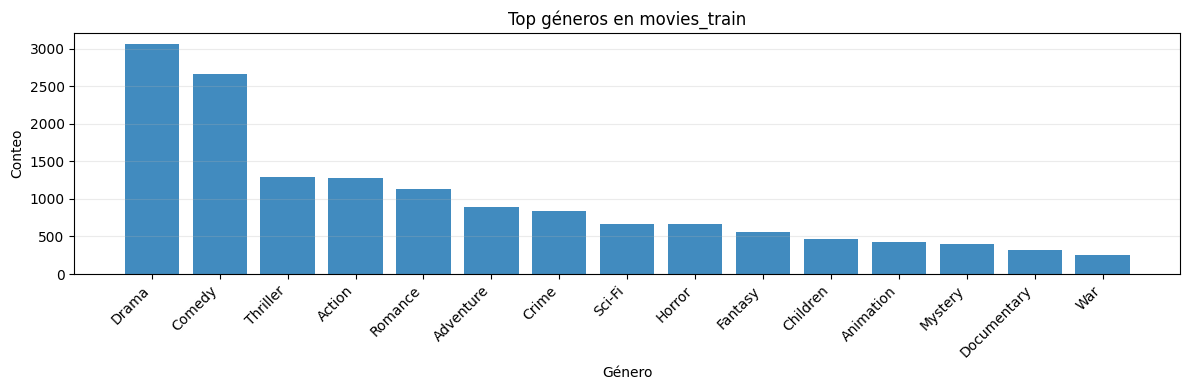

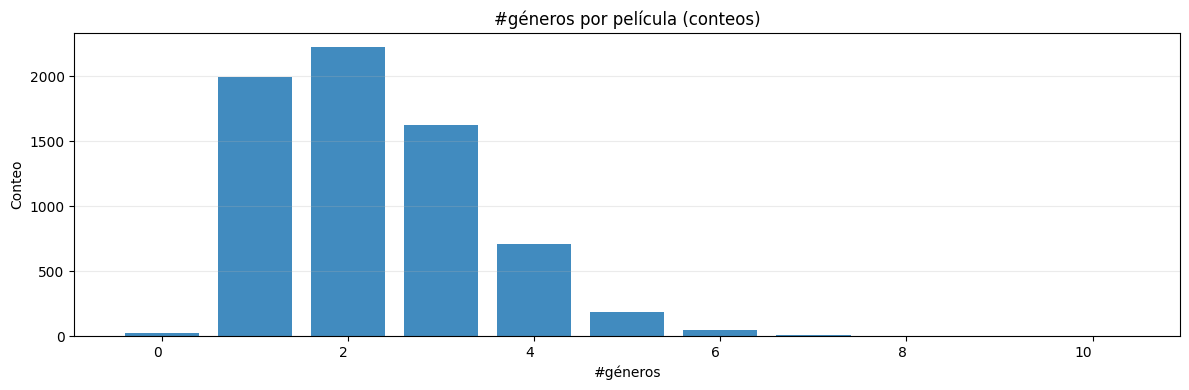


[movies_train] Top 10 combinaciones de 'genres':
  Drama: 737
  Comedy: 663
  Comedy|Drama: 312
  Comedy|Romance: 263
  Drama|Romance: 247
  Documentary: 242
  Comedy|Drama|Romance: 196
  Horror: 116
  Drama|Thriller: 108
  Crime|Drama|Thriller: 92
[movies_train] Cobertura tmdbId: 6615/6819 = 97.01%


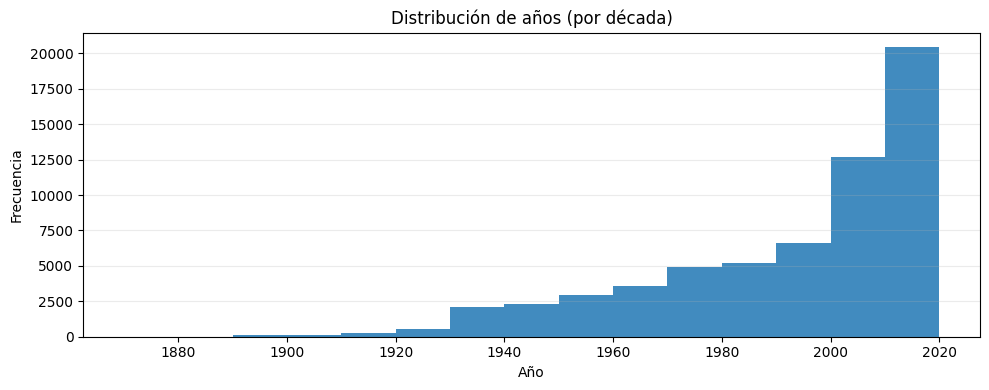

[movies] Años (min, max, count): 1874 2019 61857

[movies] Top 10 combinaciones de 'genres':
  Drama: 9056
  Comedy: 5674
  (no genres listed): 5062
  Documentary: 4731
  Comedy|Drama: 2386
  Drama|Romance: 2126
  Horror: 1661
  Comedy|Romance: 1577
  Comedy|Drama|Romance: 1044
  Drama|Thriller: 933

[links] imdbId: 62423/62423 (100.00%) | tmdbId: 62316/62423 (99.83%) | dup movieId: 0
/tmp/ipykernel_44/785290381.py:54: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  top_tags_df = (tags_lf

[tags] Top 20 tags:
  sci-fi: 8795
  atmospheric: 7053
  action: 6783
  comedy: 6366
  surreal: 5584
  funny: 5354
  based on a book: 5194
  twist ending: 4904
  visually appealing: 4691
  romance: 4458
  dystopia: 4329
  dark comedy: 4133
  quirky: 3999
  bd-r: 3966
  thought-provoking: 3847
  fantasy: 3816
  stylized: 3758
  classic: 3733
  psychology: 3646
  nudity (topless): 3590


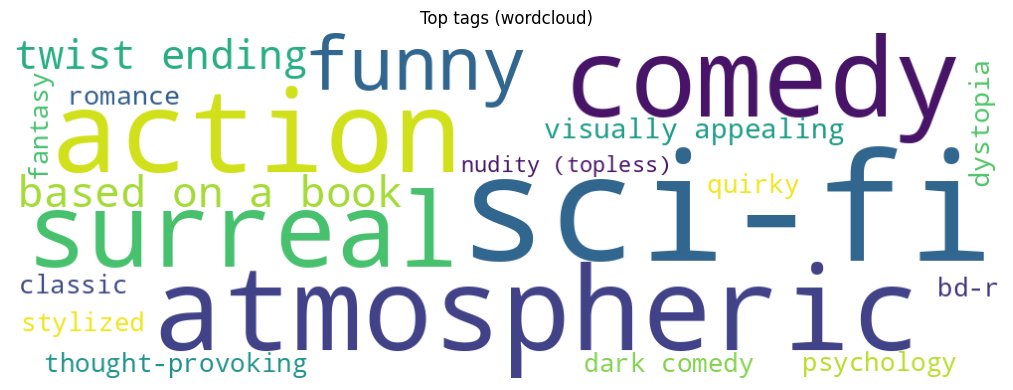

/tmp/ipykernel_44/785290381.py:70: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  tags_year = (tags_lf


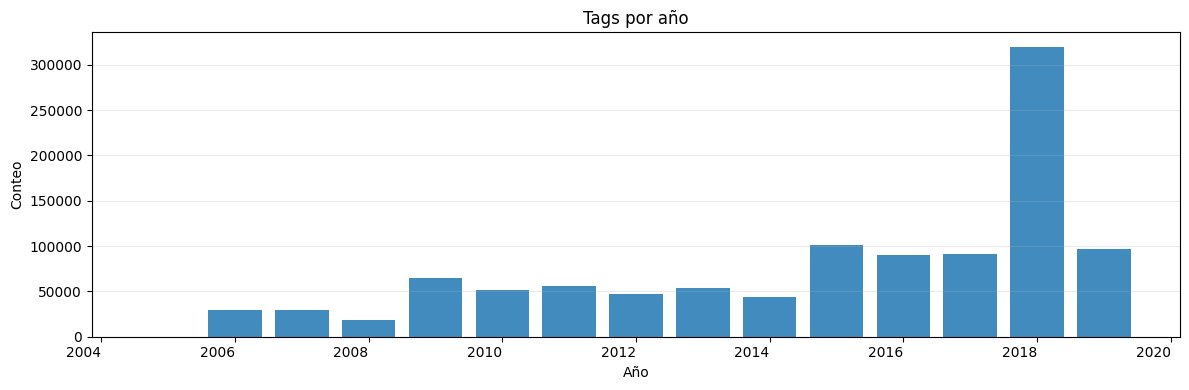

/tmp/ipykernel_44/785290381.py:81: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  stats = (genome_scores_lf

[genome_scores] stats relevance: {'min': 0.00024999999999997247, 'q25': 0.02400000000000002, 'median': 0.056499999999999995, 'q75': 0.14075, 'max': 1.0, 'mean': 0.11636786379921829}
/tmp/ipykernel_44/785290381.py:97: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  hist_df = (genome_scores_lf


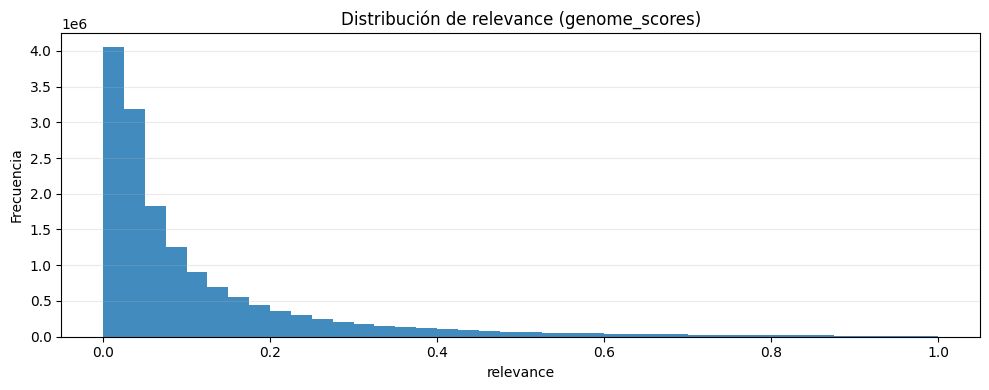

/tmp/ipykernel_44/785290381.py:113: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  gmean = (genome_scores_lf

[genome] Top 20 tags por media de relevance:
   742 | original                                 | 0.724
   646 | mentor                                   | 0.542
   188 | catastrophe                              | 0.477
   468 | great ending                             | 0.475
   972 | storytelling                             | 0.450
   867 | runaway                                  | 0.448
   302 | dialogue                                 | 0.447
   452 | good soundtrack                          | 0.429
  1104 | weird                                    | 0.423
  1070 | vengeance                                | 0.423
   195 | chase                                    | 0.413
   445 | good                                     | 0.409
   464 | great                                    | 0.404
   971 | story                            

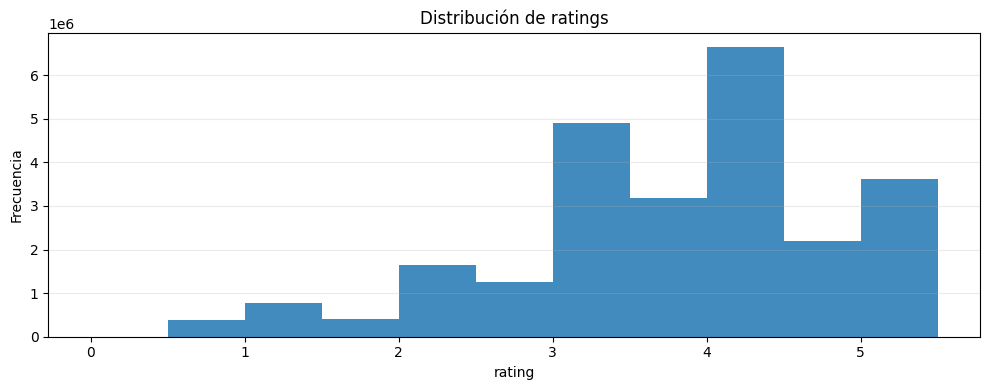


EDA ligero listo.


In [28]:
if no_gen_col:
    pct_no_gen = float(movies_train[no_gen_col].sum()) / max(1, movies_train.height)
    print(f"[movies_train] % '(no genres listed)': {pct_no_gen:.2%}")

if genre_cols:
    gen_counts = movies_train.select([pl.col(c).sum().alias(c) for c in genre_cols]).row(0)
    gen_counts = dict(zip(genre_cols, gen_counts))
    top_items  = sorted(gen_counts.items(), key=lambda x: -x[1])[:15]
    x, y = zip(*top_items)
    bar_plot(x, y, "Top géneros en movies_train", "Género", "Conteo")

    movies_train = movies_train.with_columns(total_genres = pl.sum_horizontal([pl.col(c) for c in genre_cols]))
    tg = (movies_train.group_by("total_genres").agg(pl.len().alias("n")).sort("total_genres")).to_dicts()
    x = [r["total_genres"] for r in tg]; y = [r["n"] for r in tg]
    bar_plot(x, y, "#géneros por película (conteos)", "#géneros", "Conteo", rot=0)

if "genres" in movies_train.columns:
    combos = (movies_train.group_by("genres")
              .agg(pl.len().alias("n"))
              .sort("n", descending=True).limit(10)).to_dicts()
    print("\n[movies_train] Top 10 combinaciones de 'genres':")
    for r in combos: print(f"  {r['genres']}: {r['n']}")

if "movieId" in movies_train.columns and "movieId" in links.columns:
    cov = movies_train.join(links.select(["movieId","tmdbId"]), on="movieId", how="left")
    tmdb_hit = cov.select(pl.col("tmdbId").is_not_null().sum()).item()
    print(f"[movies_train] Cobertura tmdbId: {tmdb_hit}/{movies_train.height} = {tmdb_hit/movies_train.height:.2%}")

#  2) movies 
if "title" in movies.columns:
    movies = movies.with_columns(year = pl.col("title").str.extract(r"\((\d{4})\)$").cast(pl.Int32))
    yrs = movies.drop_nulls("year")["year"].to_list()
    if yrs:
        bins = np.arange((min(yrs)//10)*10, (max(yrs)//10+1)*10 + 10, 10)
        counts, edges = np.histogram(yrs, bins=bins)
        hist_from_counts(edges, counts, "Distribución de años (por década)", "Año")
        print("[movies] Años (min, max, count):", min(yrs), max(yrs), len(yrs))

if "genres" in movies.columns:
    top_gen_combo = (movies.group_by("genres").agg(pl.len().alias("n"))
                     .sort("n", descending=True).limit(10)).to_dicts()
    print("\n[movies] Top 10 combinaciones de 'genres':")
    for r in top_gen_combo: print(f"  {r['genres']}: {r['n']}")

#  3) links 
if {"movieId","imdbId","tmdbId"}.issubset(set(links.columns)):
    total   = links.height
    imdb_ok = links.select(pl.col("imdbId").is_not_null().sum()).item()
    tmdb_ok = links.select(pl.col("tmdbId").is_not_null().sum()).item()
    dup_mv  = links.select(pl.col("movieId").is_duplicated().sum()).item()
    print(f"\n[links] imdbId: {imdb_ok}/{total} ({imdb_ok/total:.2%}) | tmdbId: {tmdb_ok}/{total} ({tmdb_ok/total:.2%}) | dup movieId: {dup_mv}")

#  4) tags (LAZY) 
top_tags_df = (tags_lf
    .select(pl.col("tag").cast(pl.Utf8).str.to_lowercase().alias("tag_lc"))
    .group_by("tag_lc").len()
    .sort("len", descending=True)
    .limit(20)
    .collect(streaming=True)
)
print("\n[tags] Top 20 tags:")
for tag, n in zip(top_tags_df["tag_lc"], top_tags_df["len"]):
    print(f"  {tag}: {n}")
freq = dict(zip(top_tags_df["tag_lc"].to_list(), top_tags_df["len"].to_list()))
if freq:
    wc = WordCloud(width=1000, height=350, background_color="white").generate_from_frequencies(freq)
    plt.figure(figsize=(12,4)); plt.imshow(wc); plt.axis("off"); plt.title("Top tags (wordcloud)")
    plt.tight_layout(); plt.show(); plt.close()

tags_year = (tags_lf
    .select(pl.from_epoch(pl.col("timestamp"), time_unit="s").dt.year().alias("year"))
    .group_by("year").len()
    .sort("year")
    .collect(streaming=True)
)
bar_plot(tags_year["year"].to_list(), tags_year["len"].to_list(),
         "Tags por año", "Año", "Conteo", rot=0)

# 5) genome_scores (LAZY)
# Stats (nos aseguramos de que 'relevance' sea float)
stats = (genome_scores_lf
    .with_columns(pl.col("relevance").cast(pl.Float64))
    .select([
        pl.col("relevance").min().alias("min"),
        pl.col("relevance").quantile(0.25).alias("q25"),
        pl.col("relevance").median().alias("median"),
        pl.col("relevance").quantile(0.75).alias("q75"),
        pl.col("relevance").max().alias("max"),
        pl.col("relevance").mean().alias("mean"),
    ])
    .collect(streaming=True)
)
print("\n[genome_scores] stats relevance:", stats.to_dicts()[0])

# Histograma (40 bins)
B = 40
hist_df = (genome_scores_lf
    .with_columns(pl.col("relevance").cast(pl.Float64))
    .select(((pl.col("relevance") * B)
             .cast(pl.Int32)
             .clip(0, B-1)).alias("bin"))   # <<<< cambio clave
    .group_by("bin").len()
    .sort("bin")
    .collect(streaming=True)
)
counts = np.zeros(B, dtype=int)
for b, n in zip(hist_df["bin"].to_list(), hist_df["len"].to_list()):
    counts[int(b)] = n
edges = np.linspace(0, 1, B+1)
hist_from_counts(edges, counts, "Distribución de relevance (genome_scores)", "relevance")

# Top tags por media de relevance
gmean = (genome_scores_lf
    .with_columns(pl.col("relevance").cast(pl.Float64))
    .group_by("tagId")
    .agg(pl.col("relevance").mean().alias("mean_rel"))
    .sort("mean_rel", descending=True)
    .limit(20)
    .collect(streaming=True)
).join(genome_tags, on="tagId", how="left")
print("\n[genome] Top 20 tags por media de relevance:")
for r in gmean.to_dicts():
    print(f"  {r['tagId']:>4} | {r.get('tag','?')[:40]:<40} | {r['mean_rel']:.3f}")

# 6) ratings (LAZY)
try:
    n_ratings = ratings_lf.select(pl.count()).collect(streaming=True).item()
except Exception:
    n_ratings = 0

if n_ratings > 0:
    rstats = (ratings_lf
        .with_columns(pl.col("rating").cast(pl.Float64))
        .select([
            pl.count().alias("n"),
            pl.col("rating").mean().alias("mean"),
            pl.col("rating").std().alias("std"),
            pl.col("rating").min().alias("min"),
            pl.col("rating").median().alias("median"),
            pl.col("rating").max().alias("max"),
        ])
        .collect(streaming=True)
    ).to_dicts()[0]
    print("\n[ratings] stats:", rstats)

    hist_rt = (ratings_lf
        .with_columns(pl.col("rating").cast(pl.Float64))
        .select(((pl.col("rating")*2).round(0).cast(pl.Int32)).alias("bin"))
        .group_by("bin").len()
        .sort("bin")
        .collect(streaming=True)
    )
    edges = np.arange(0, 5.5+0.5, 0.5)   # 0.0..5.5 paso 0.5
    counts = np.zeros(len(edges)-1, dtype=int)
    for b, n in zip(hist_rt["bin"].to_list(), hist_rt["len"].to_list()):
        if 0 <= b < len(counts):
            counts[b] = n
    hist_from_counts(edges, counts, "Distribución de ratings", "rating")
else:
    print("\n[ratings] vacío o no disponible; lo omitimos.")

gc.collect()
print("\nEDA ligero listo.")

# EDA — Interpretación de gráficos y salidas

## 1) Top géneros en `movies_train` (gráfico de barras)
**Lo que muestra:**  
Barras altas para **Drama (~3,058)** y **Comedy (~2,659)**; después **Thriller (~1,298)**, **Action (~1,279)**, **Romance (~1,138)**; el resto decrece (Adventure, Crime, Sci-Fi, Horror, …).

**Lectura:**  
- Hay desbalance fuerte: 2–3 géneros concentran gran parte del set.  
- Los géneros minoritarios (p.ej. War, Documentary, Western) tienen poca representación.

**Implicación para tu análisis:**  
- Cualquier métrica “global” de coherencia por género tenderá a favorecer a Drama/Comedy.  
- Cuando evalúes resultados, conviene estratificar por género (o al menos señalar el sesgo).

---

## 2) #géneros por película (histograma de barras)
**Lo que muestra:**  
La masa está en **1–3 géneros por título**; hay cola corta con **≥4**.

**Lectura:**  
- La mayoría de las películas está poco multietiquetada.  
- Películas con muchos géneros son menos frecuentes.

**Implicación:**  
- Donde hay 1–2 géneros, esperarás señales más “puras”; cuando hay ≥3, es más normal que el estilo (e incluso la semántica) sea mezclado.

---

## 3) Distribución de años (por década) (histograma)
**Lo que muestra:**  
Crecimiento fuerte a partir de **1990s, 2000s, 2010s**; extremos antiguos con baja frecuencia. En `movies` detectaste años entre **1874–2019 (61,857 con año)**.

**Lectura:**  
- El set está sesgado temporalmente hacia décadas recientes.  
- Los estilos de póster cambian por época (tipografía, paletas, composición).

**Implicación:**  
- Las comparaciones/agrupamientos pueden reflejar moda temporal además de similitud “intrínseca”.

---

## 4) Wordcloud de tags de usuarios
**Lo que muestra (palabras destacadas):**  
*sci-fi, atmospheric, action, comedy, surreal, funny, based on a book, twist ending, visually appealing, dark comedy, quirky, fantasy, psychology, …*

**Lectura:**  
- Mezcla de género (sci-fi), tono/atmósfera (atmospheric, surreal), rasgos narrativos (twist ending, based on a book) y algo de ruido.  
- El tag **“visually appealing”** conecta bien con tu enfoque de similitud visual.

**Implicación:**  
- Para comunicar resultados, estos tags sirven como etiquetas interpretables (p. ej., “cluster con atmósfera/surreal”).  
- Si hicieras conteos, conviene normalizar a lowercase y filtrar ruido (tú ya pasaste a minúsculas).

---

## 5) Tags por año (barras)
**Lo que muestra:**  
Aumento general de actividad con picos claros (**2018** muy alto).

**Lectura:**  
- Refleja uso de la plataforma a lo largo del tiempo, no calidad de películas.

**Implicación:**  
- No interpretar estos picos como “mejores películas” sino como mayor volumen de etiquetado.

---

## 6) Distribución de `relevance` en `genome_scores` (histograma de 40 bins)
**Lo que muestra (estadísticos):**  
`min≈0.00025`, `q25≈0.024`, `mediana≈0.0565`, `q75≈0.1408`, `max=1.0`, `media≈0.1164`.  
Histograma muy sesgado a valores bajos; pocos valores altos.

**Lectura:**  
- Por película, pocos tags son realmente muy relevantes; la mayoría aporta señal débil.

**Implicación:**  
- Si comparas semántica entre películas, tiene sentido priorizar tags de mayor relevance (**top-K o umbral**) para evitar que el ruido “aplane” similitudes.  

**Apunte extra (de tus prints):**  
- Top tags por media de relevance incluyen *original, mentor, great ending, storytelling, visually appealing,* etc. → útiles para describir grupos.

---

## 7) Distribución de ratings (histograma, paso 0.5)
**Lo que muestra (estadísticos):**  
`n=25,000,095`, `media≈3.53`, `mediana=3.5`, `std≈1.06`, rango `[0.5, 5.0]`.

**Lectura:**  
- Distribución típica de MovieLens, centrada cerca de **3.5**.

**Implicación:**  
- Si usas un “baseline” o respaldo por popularidad, conviene exigir **mínimo de votos** por película (evita llamar “popular” a items con 1–2 ratings).

---

## 8) Resúmenes tabulares que imprimiste
- **(no genres listed)** en train: **0.37%** → insignificante.  
- **Cobertura `tmdbId` en train:** `6615/6819 = 97.01%` (y `imdbId` 100% en `links`).  
- **Top combinaciones de `genres`:**  
  - En `movies_train`: *Drama*, *Comedy*, *Comedy|Drama*, *Comedy|Romance*, *Drama|Romance*, *Documentary*, …  
  - En `movies` (catálogo): *Drama*, *Comedy*, *(no genres listed)*, *Documentary*, *Comedy|Drama*, …  
  → Confirma las co-ocurrencias más frecuentes (**Comedy–Drama**, **Drama–Romance**), útiles como referencia al revisar vecinos.

---

## 9) Notas sobre tu código (solo lo que se ve)
- Usaste **Polars Lazy (`scan_csv`)** en tablas grandes → correcto para memoria y velocidad.  
- **Warnings** deprecados: `streaming` (usar `engine`), `pl.count()` (usar `pl.len()`), `melt()` (usar `unpivot()`), `is_in` ambiguo (mejor **semi-join**).  
  → No afectan la interpretación; son ajustes sintácticos cuando quieras limpiar el notebook.

---

## Conclusiones (derivadas de tus figuras y salidas)
- El set está **sano** y con **cobertura altísima** de IDs externos → buen terreno para un enfoque visual.  
- Hay **desbalance de géneros** y **sesgo temporal** a 1990s–2010s → al analizar resultados, conviene **estratificar** (por género y, cuando sea relevante, por década).  
- En `genome_scores`, la señal fuerte está en **pocos tags por película** → al comparar semántica, **priorizar top-K/umbral**.  
- En `ratings`, la distribución es estándar → si usas popularidad como apoyo, aplica **umbral mínimo de votos**.


Películas con >=1 tag fuerte (>0.2): 88.87%


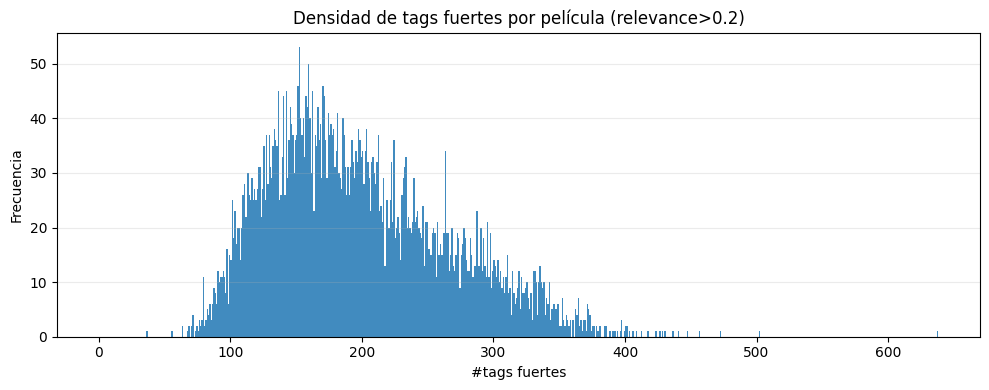

In [31]:
# ids de train como LazyFrame pequeño
train_ids_lf = movies_train.select("movieId").unique().lazy()

THR = 0.2  # prueba también 0.3
strong = (
    genome_scores_lf
    .join(train_ids_lf, on="movieId", how="inner")
    .filter(pl.col("relevance") > THR)
    .group_by("movieId").agg(pl.len().alias("n_strong"))
    .collect()
)

print(f"Películas con >=1 tag fuerte (>{THR}): { (strong.height / movies_train.height):.2%}")

# histograma de densidad de tags fuertes por película
vals = strong["n_strong"].to_list()
plt.figure(figsize=(10,4))
plt.hist(vals, bins=np.arange(0, max(vals)+2, 1), alpha=.85)
plt.title(f"Densidad de tags fuertes por película (relevance>{THR})")
plt.xlabel("#tags fuertes"); plt.ylabel("Frecuencia"); plt.grid(axis='y', alpha=.25)
plt.tight_layout(); plt.show()


# EDA — “Tags fuertes” (genome) con relevance > 0.2

**Cobertura:**  
- Películas con ≥1 tag fuerte (>0.2): **88.87%**

## Histograma de #tags fuertes por película
**Qué muestra el gráfico**  
- **Eje X:** número de tags fuertes por película (relevance > 0.2)  
- **Eje Y:** frecuencia de películas con ese conteo  
- **Forma:** masa principal ~**100–250**; pico aprox. **150–200**; cola hacia la derecha (casos **300–400+**); muy pocas por debajo de **~80**.

**Lectura**  
- La mayoría tiene **centenas** de tags fuertes (no 5–10 → señal densa).  
- Distribución **asimétrica**: pico en ~150–200 y descenso gradual (cola larga).  
- El **88.87%** cuadra con la cobertura previa de *genome_scores*: casi todas las que tienen genome poseen ≥1 tag fuerte a este umbral.

## Por qué importa (para el recomendador visual)
- **Validación semántica**: si dos pósters son vecinos visuales, deberían **compartir** muchos tags fuertes.  
- **Fallback sin ratings**: similitud por **coseno** de vectores de relevance (normalizados y umbralizados) cuando falte imagen.

## Decisiones prácticas
- **Umbral + normalización**: mantener **>0.2** y probar **0.3** (sensibilidad). Normalizar **L2** antes del coseno para evitar sesgos por magnitud.  
- **Cap de dimensionalidad**: usar **Top-K** por película (p. ej., **K=100**) para vectores manejables y comparables.  
- **Métricas complementarias**: además del coseno, **Jaccard** sobre el conjunto de tags fuertes (binario, explicable).

## Análisis estratificado
- Repetir densidad por **género** y **década**: grupos con menos tags fuertes tendrán validación más ruidosa (contextualiza resultados).

## Señales a vigilar (outliers)
- **>400** tags fuertes: títulos muy generales / sobreetiquetados → considerar **cap** o **TF-IDF** para bajar peso a términos universales.  
- **<80** tags fuertes: semántica frágil → evitar basar validación solo en esos casos.

## Conclusión
- El corte confirma **semántica rica** para ~**89%** del *train*.  
- Útil y necesario en la EDA para:  
  - **Validar** similitud visual (¿comparten tags fuertes?).  
  - **Sustituir** imagen ausente con señal genome.

**Siguiente paso:** comparar, para un conjunto de *queries*, los **vecinos visuales** vs. **vecinos genome** (coseno/Top-K) y reportar **overlap** de vecinos y **correlación** de distancias.



Top 20 tags para Action (thr>0.2):
  shakespeare                               mean=0.995  n=1
  peter pan                                 mean=0.987  n=1
  emma watson                               mean=0.951  n=2
  vampires                                  mean=0.945  n=14
  vampire                                   mean=0.922  n=14
  spock                                     mean=0.908  n=3
  batman                                    mean=0.878  n=12
  007 (series)                              mean=0.853  n=39
  james bond                                mean=0.790  n=27
  martial arts                              mean=0.763  n=190
  world war ii                              mean=0.761  n=46
  soccer                                    mean=0.755  n=3
  action                                    mean=0.748  n=1074
  original                                  mean=0.739  n=1130
  surfing                                   mean=0.734  n=6
  animation                                 mean=0

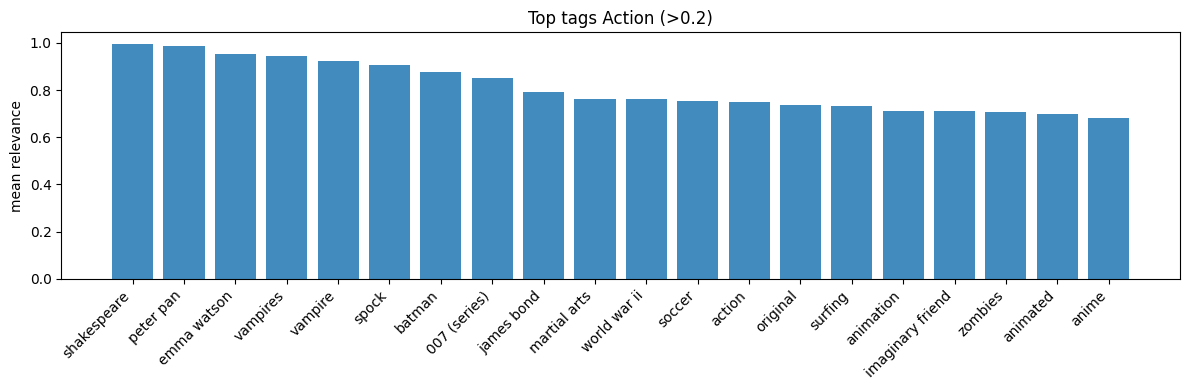


Top 20 tags para Romance (thr>0.2):
  video game adaptation                     mean=0.992  n=1
  emma watson                               mean=0.990  n=1
  vampire                                   mean=0.986  n=4
  figure skating                            mean=0.951  n=2
  beatles                                   mean=0.946  n=1
  sophia coppola                            mean=0.907  n=3
  vampires                                  mean=0.862  n=5
  james bond                                mean=0.851  n=1
  mockumentary                              mean=0.846  n=1
  anime                                     mean=0.820  n=10
  martial arts                              mean=0.814  n=16
  rio de janeiro                            mean=0.812  n=5
  animation                                 mean=0.772  n=33
  kung fu                                   mean=0.770  n=15
  swedish                                   mean=0.769  n=3
  kurosawa                                  mean=0.744  n=1

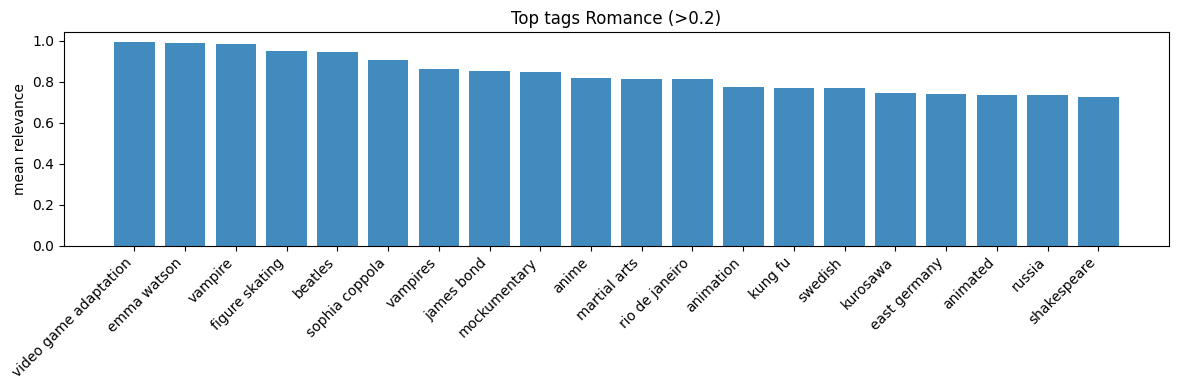

In [34]:
def top_tags_por_genero(genre="Action", thr=0.2, k=20):
    # películas de ese género en train
    gen_movies = (
        movies_train.select(["movieId","genres"])
        .with_columns(pl.col("genres").str.split("|").alias("gen_list"))
        .explode("gen_list")
        .filter(pl.col("gen_list")==genre)
        .select("movieId")
        .lazy()
    )

    res = (
        genome_scores_lf
        .join(gen_movies, on="movieId", how="inner")
        .filter(pl.col("relevance") > thr)
        .group_by("tagId")
        .agg([
            pl.col("relevance").mean().alias("mean_rel"),
            pl.len().alias("n_pairs")
        ])
        .sort(["mean_rel","n_pairs"], descending=[True,True])
        .limit(k)
        .collect()
        .join(genome_tags, on="tagId", how="left")
        .sort("mean_rel", descending=True)
    )

    print(f"\nTop {k} tags para {genre} (thr>{thr}):")
    for r in res.to_dicts():
        print(f"  {r['tag'][:40]:<40}  mean={r['mean_rel']:.3f}  n={r['n_pairs']}")

    # barplot rápido
    plt.figure(figsize=(12,4))
    plt.bar(res["tag"].to_list(), res["mean_rel"].to_list(), alpha=.85)
    plt.xticks(rotation=45, ha='right'); plt.title(f"Top tags {genre} (>{thr})")
    plt.ylabel("mean relevance"); plt.tight_layout(); plt.show()

# Ejemplos:
top_tags_por_genero("Action", thr=0.2, k=20)
top_tags_por_genero("Romance", thr=0.2, k=20)


**Top-tags por género:** muestran subfamilias temáticas coherentes (p. ej., *Action* de artes marciales o bélico; *Romance* animado/juvenil y fantástico).  
Para evitar sesgos por entidades y tags ubicuos, **filtramos por soporte mínimo**, **unificamos variantes** y **priorizamos métricas discriminativas** (*lift* / *IDF*).  
Estos tags **servirán para nombrar clusters visuales** y **validar** que la similitud por pósters refleje **temas reconocibles**.


/tmp/ipykernel_44/1399208148.py:28: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  mv_year_gen.filter(pl.col("genre").is_in(topg))


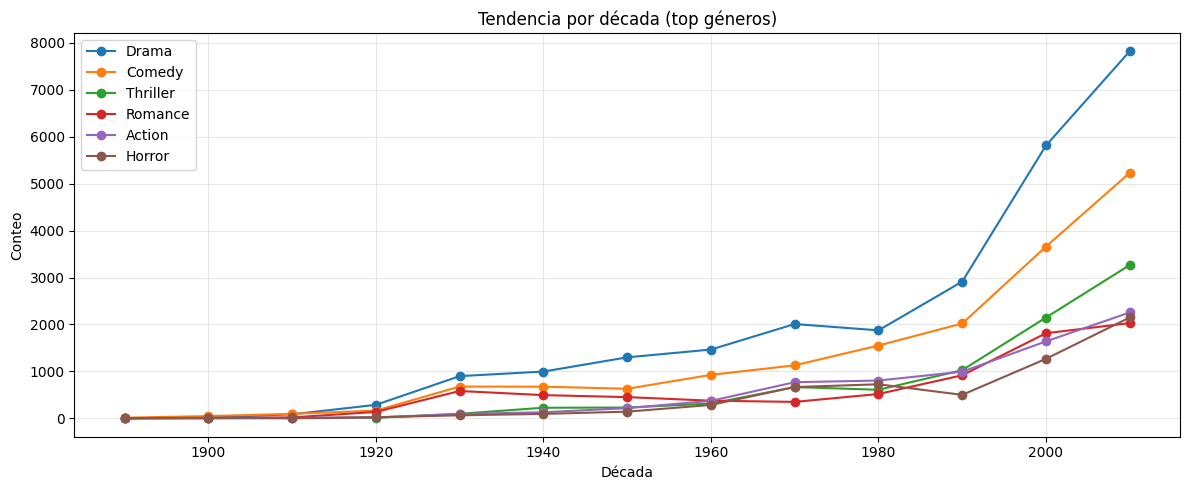

In [37]:
mv_year_gen = (
    movies
    .with_columns([
        pl.col("title").str.extract(r"\((\d{4})\)$").cast(pl.Int32).alias("year"),
        pl.when(pl.col("genres") != "(no genres listed)")
          .then(pl.col("genres").str.split("|"))
          .otherwise(pl.lit([])).alias("gen_list")
    ])
    .drop_nulls("year")
    .with_columns(
        decade = ((pl.col("year") / 10).floor() * 10).cast(pl.Int32)  # << sin floor_div
    )
    .explode("gen_list")
    .rename({"gen_list": "genre"})
    .filter(pl.col("genre") != "")
    .group_by(["decade","genre"]).agg(pl.len().alias("n"))
    .sort(["decade","genre"])
)

# Top 6 géneros globales
topg = (
    mv_year_gen.group_by("genre").agg(pl.col("n").sum().alias("tot"))
    .sort("tot", descending=True).head(6)["genre"].to_list()
)

# Tabla ancha (década x género)
trend = (
    mv_year_gen.filter(pl.col("genre").is_in(topg))
    .pivot(values="n", index="decade", columns="genre")
    .fill_null(0)
    .sort("decade")
)

# Plot
plt.figure(figsize=(12,5))
for g in topg:
    plt.plot(trend["decade"].to_list(), trend[g].to_list(), marker="o", label=g)
plt.title("Tendencia por década (top géneros)")
plt.xlabel("Década"); plt.ylabel("Conteo"); plt.grid(alpha=.3)
plt.legend(); plt.tight_layout(); plt.show()


**Sesgo temporal y de géneros:** el catálogo está muy sesgado a **1990s–2010s**, con **Drama/Comedy** dominantes y fuerte crecimiento reciente de **Action/Thriller/Horror**.  
**Decisión metodológica:** las comparaciones visuales y la evaluación de coherencia se harán **estratificadas por década** y también **ponderadas por proporción de cada década**, para evitar confundir **estilo temporal** con **similitud de contenido**.


In [43]:
# conteos por género y matriz de co-ocurrencia
tot = movies_train.select([pl.col(g).sum().alias(g) for g in gcols]).row(0)
tot = dict(zip(gcols, tot))

pairs = []
for i in range(len(gcols)):
    gi = gcols[i]
    for j in range(i+1, len(gcols)):
        gj = gcols[j]
        cij = movies_train.select(((pl.col(gi) > 0) & (pl.col(gj) > 0)).cast(pl.Int64).sum().alias("c")).item()
        if cij > 0:
            # Jaccard entre conjuntos binarios
            uij = tot[gi] + tot[gj] - cij
            jacc = cij / uij if uij else 0.0
            pairs.append((gi, gj, cij, jacc))

# Top por co-ocurrencia y por jaccard
top_c = sorted(pairs, key=lambda t: -t[2])[:15]
top_j = sorted(pairs, key=lambda t: -t[3])[:15]

print("\nTop 15 pares por co-ocurrencia (conteo):")
for gi, gj, c, j in top_c: print(f"{gi:10s} & {gj:10s}  c={c:4d}  jacc={j:.3f}")
print("\nTop 15 pares por similitud Jaccard:")
for gi, gj, c, j in top_j: print(f"{gi:10s} & {gj:10s}  c={c:4d}  jacc={j:.3f}")


Top 15 pares por co-ocurrencia (conteo):
Comedy     & Drama       c= 727  jacc=0.146
Drama      & Romance     c= 663  jacc=0.188
Comedy     & Romance     c= 642  jacc=0.203
Drama      & Thriller    c= 577  jacc=0.153
Action     & Thriller    c= 444  jacc=0.208
Crime      & Drama       c= 444  jacc=0.129
Action     & Adventure   c= 428  jacc=0.245
Crime      & Thriller    c= 400  jacc=0.231
Action     & Drama       c= 381  jacc=0.096
Action     & Comedy      c= 316  jacc=0.087
Horror     & Thriller    c= 307  jacc=0.185
Action     & Sci-Fi      c= 301  jacc=0.183
Action     & Crime       c= 295  jacc=0.162
Adventure  & Comedy      c= 288  jacc=0.088
Mystery    & Thriller    c= 246  jacc=0.169

Top 15 pares por similitud Jaccard:
Animation  & Children    c= 211  jacc=0.311
Action     & Adventure   c= 428  jacc=0.245
Crime      & Thriller    c= 400  jacc=0.231
Action     & Thriller    c= 444  jacc=0.208
Comedy     & Romance     c= 642  jacc=0.203
Adventure  & Children    c= 226  jacc=0.1

### Co-ocurrencia y Jaccard de géneros — incluir en la EDA

**Qué mide**
- **Co-ocurrencia (c):** # de películas con ambos géneros (favorece géneros grandes).
- **Jaccard:** \( c / (|A| + |B| - c) \) → normaliza por tamaño, resalta afinidades “proporcionales”.

**Para qué sirve**
- Base semántica independiente de imágenes para **validar** clusters/vecinos visuales.
- Explica mezclas típicas (p.ej., *Comedy–Romance*, *Action–Thriller*).

**Cómo reportarlo (breve)**
- **Top-5 por co-ocurrencia** (muestra c y su Jaccard) + 1 línea de lectura.
- **Top-5 por Jaccard** (afinidades limpias) + 1 línea de lectura.

**Recomendaciones**
- **Soporte mínimo:** \( c \ge 50 \) (ajusta según tamaño).
- Nota: películas multigénero inflan co-ocurrencias; **Jaccard corrige parcialmente**.
- (Opcional) Heatmap de Jaccard y/o corte por **década**.



Top 20 tags (lift) para Action | thr>0.2, min_supp=30
  dc comics                                lift=5.16  m_tag_gen=62  m_tag=64
  marvel                                   lift=4.91  m_tag_gen=93  m_tag=101
  explosions                               lift=4.88  m_tag_gen=421  m_tag=460
  martial arts                             lift=4.85  m_tag_gen=190  m_tag=209
  kung fu                                  lift=4.74  m_tag_gen=199  m_tag=224
  arms dealer                              lift=4.48  m_tag_gen=304  m_tag=362
  based on comic                           lift=4.42  m_tag_gen=121  m_tag=146
  wuxia                                    lift=4.40  m_tag_gen=76  m_tag=92
  hong kong                                lift=4.39  m_tag_gen=116  m_tag=141
  heroine in tight suit                    lift=4.36  m_tag_gen=72  m_tag=88
  comic book                               lift=4.33  m_tag_gen=216  m_tag=266
  ninja                                    lift=4.28  m_tag_gen=276  m_tag=344
  su

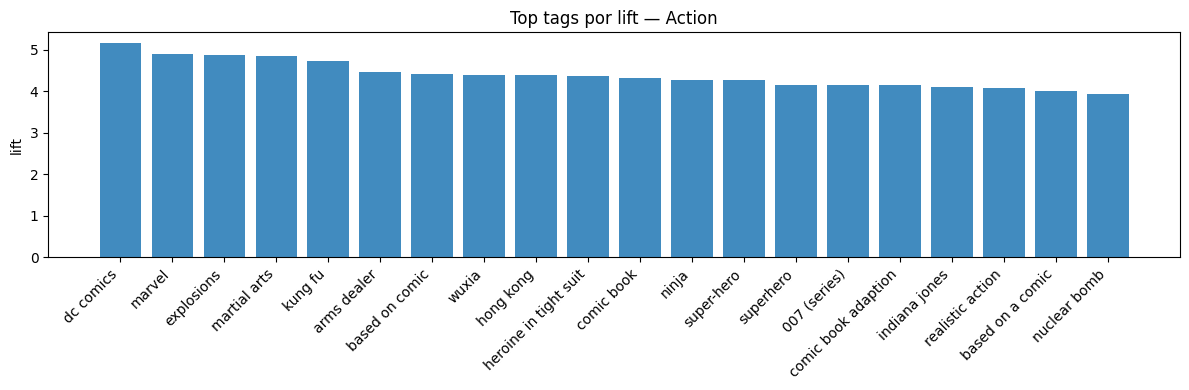


Top 20 tags (lift) para Romance | thr>0.2, min_supp=30
  good romantic comedies                   lift=4.88  m_tag_gen=273  m_tag=335
  jane austen                              lift=4.72  m_tag_gen=26  m_tag=33
  wedding                                  lift=3.91  m_tag_gen=169  m_tag=259
  love triangles                           lift=3.58  m_tag_gen=234  m_tag=392
  romantic comedy                          lift=3.48  m_tag_gen=529  m_tag=910
  chick flick                              lift=3.39  m_tag_gen=464  m_tag=819
  sappy                                    lift=3.11  m_tag_gen=239  m_tag=460
  screwball comedy                         lift=2.73  m_tag_gen=102  m_tag=224
  romance                                  lift=2.71  m_tag_gen=909  m_tag=2010
  sweet                                    lift=2.68  m_tag_gen=530  m_tag=1185
  marriage                                 lift=2.67  m_tag_gen=421  m_tag=945
  romantic                                 lift=2.67  m_tag_gen=881  m_tag=

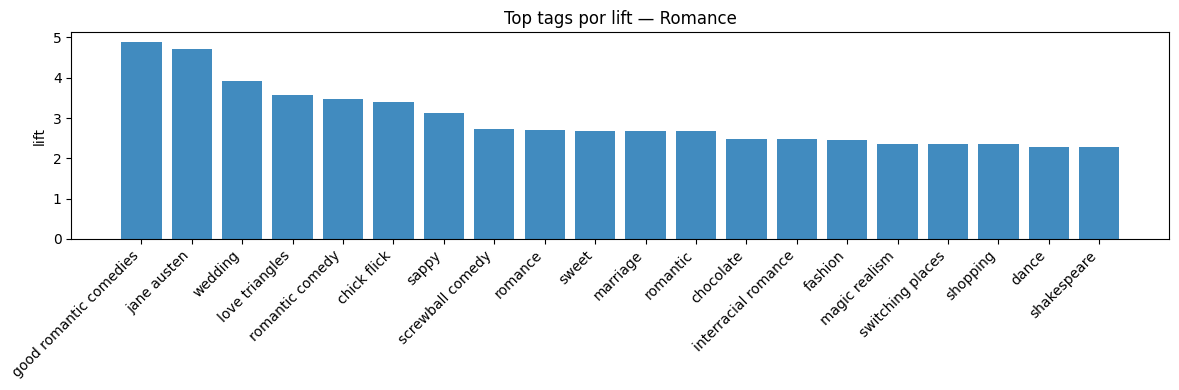

In [46]:
thr = 0.2         # umbral de tag "fuerte"
min_supp = 30     # soporte mínimo de películas con el tag en train

# películas de train explotadas por género
train_gen_lf = (
    movies_train.select(["movieId","genres"])
    .with_columns(pl.col("genres").str.split("|").alias("genre"))
    .explode("genre")
    .filter(pl.col("genre") != "")
    .lazy()
)

# número de pelis por género (para P(.|género))
m_gen = (train_gen_lf.group_by("genre").agg(pl.len().alias("m_gen")).collect())

# pares (movieId, tagId) fuertes (únicos) dentro de train
train_ids_lf = movies_train.select("movieId").unique().lazy()
strong_pairs = (
    genome_scores_lf
    .join(train_ids_lf, on="movieId", how="inner")
    .filter(pl.col("relevance") > thr)
    .select(["movieId","tagId"]).unique()
    .lazy()
)

# totales por tag en train (para P(tag))
tag_tot = strong_pairs.group_by("tagId").agg(pl.len().alias("m_tag")).collect()

# conteos por tag y género
tg = (
    strong_pairs
    .join(train_gen_lf, on="movieId", how="inner")
    .group_by(["genre","tagId"]).agg(pl.len().alias("m_tag_gen"))
    .collect()
)

# lift = (m_tag_gen / m_gen) / (m_tag / |train|)
M = movies_train.height
lift_tbl = (
    tg.join(m_gen, on="genre", how="left")
      .join(tag_tot, on="tagId", how="left")
      .with_columns([
          (pl.col("m_tag_gen") / pl.col("m_gen")).alias("p_tag_given_gen"),
          (pl.col("m_tag")     / M).alias("p_tag")
      ])
      .with_columns((pl.col("p_tag_given_gen") / pl.col("p_tag")).alias("lift"))
      .filter(pl.col("m_tag") >= min_supp)
      .join(genome_tags, on="tagId", how="left")
)

def top_tags_lift(genre="Action", k=20):
    res = (lift_tbl.filter(pl.col("genre")==genre)
           .sort("lift", descending=True).head(k))
    print(f"\nTop {k} tags (lift) para {genre} | thr>{thr}, min_supp={min_supp}")
    for r in res.to_dicts():
        print(f"  {r['tag'][:40]:<40} lift={r['lift']:.2f}  m_tag_gen={r['m_tag_gen']}  m_tag={r['m_tag']}")
    # gráfico
    plt.figure(figsize=(12,4))
    plt.bar(res["tag"].to_list(), res["lift"].to_list(), alpha=.85)
    plt.xticks(rotation=45, ha='right'); plt.title(f"Top tags por lift — {genre}")
    plt.ylabel("lift"); plt.tight_layout(); plt.show()

# Ejemplos:
top_tags_lift("Action", k=20)
top_tags_lift("Romance", k=20)

### Top tags por *lift* — interpretación (relevance > 0.2, min_supp = 30)

**Definición:**  
Lift = P(tag | género) / P(tag) → >1 = sobre-representación del tag en ese género.

**Por qué usarlo:**  
Penaliza tags ubicuos y resalta los **característicos** del género (más explicativos que la media de relevance).

**Action — Top por lift (≈4–5):**  
- **Superhéroes/comic:** dc comics, marvel, super-hero, comic book, based on (a) comic, 007.  
- **Artes marciales/Asia:** martial arts, kung fu, wuxia, hong kong, ninja.  
- **Bélico/armas:** arms dealer, explosions, nuclear bomb, realistic action.  
- **Aventura pulp:** indiana jones.

**Romance — Top por lift:**  
- **Rom-com:** romantic comedy, good romantic comedies, chick flick, screwball comedy, love triangles.  
- **Vínculos/ceremonias:** wedding, marriage, sweet, sappy.  
- **Literatura/autor:** jane austen, shakespeare.  
- **Temas extra:** interracial romance, fashion, shopping, dance, magic realism.

**Uso práctico (EDA/modelo):**  
- **Nombrar clusters visuales** con tags de alto lift (p.ej., *Action—Superhéroes*, *Romance—Rom-com*).  
- **Validar vecinos**: medir % de vecinos que contienen Top-K tags por lift del mismo género.  
- **Diversificación**: alternar subfamilias (superhéroes vs. artes marciales vs. bélico).

**En una línea:**  
“El corte por *lift* identifica tags **altamente característicos** por género; los usamos para **nombrar/validar** clusters visuales y guiar la **diversificación temática**.”


In [52]:
# cobertura de tmdbId
cov_tmdb = links.select(["movieId","tmdbId"])
# densidad de tags fuertes por película (del bloque de 'strong' que ya hiciste)
tags_strong = strong.rename({"n_strong":"n_tags_strong"})  # movieId, n_tags_strong

# ratings por película (ya en movie_stats)
sig = (
    movies_train.select(["movieId","title","genres"])
    .join(cov_tmdb, on="movieId", how="left")
    .join(movie_stats.select(["movieId","n"]).rename({"n":"n_ratings"}), on="movieId", how="left")
    .join(tags_strong, on="movieId", how="left")
    .with_columns([
        pl.col("tmdbId").is_not_null().alias("has_poster"),
        pl.col("n_ratings").fill_null(0),
        pl.col("n_tags_strong").fill_null(0)
    ])
)

# resumen
tot = sig.height
print("\nCobertura en train:")
print(" posters TMDb:", sig.select(pl.col("has_poster").sum()).item(), f"({sig.select(pl.col('has_poster').mean()).item():.2%})")
print(" ≥1 rating   :", sig.select((pl.col("n_ratings")>0).sum()).item(), f"({sig.select((pl.col('n_ratings')>0).mean()).item():.2%})")
print(" ≥1 tag fuerte:", sig.select((pl.col("n_tags_strong")>0).sum()).item(), f"({sig.select((pl.col('n_tags_strong')>0).mean()).item():.2%})")

# lista de películas “difíciles”
hard = sig.filter((pl.col("has_poster")==False) | ((pl.col("n_ratings")==0) & (pl.col("n_tags_strong")==0))) \
          .select(["movieId","title","genres","has_poster","n_ratings","n_tags_strong"]) \
          .sort(["has_poster","n_ratings","n_tags_strong"])
print("\nMuestras de 'difíciles' (sin poster o sin señal):")
print(hard.head(20))



Cobertura en train:
 posters TMDb: 6615 (97.01%)
 ≥1 rating   : 6618 (97.05%)
 ≥1 tag fuerte: 6060 (88.87%)

Muestras de 'difíciles' (sin poster o sin señal):
shape: (20, 6)
┌─────────┬───────────────────────┬───────────────────────┬────────────┬───────────┬───────────────┐
│ movieId ┆ title                 ┆ genres                ┆ has_poster ┆ n_ratings ┆ n_tags_strong │
│ ---     ┆ ---                   ┆ ---                   ┆ ---        ┆ ---       ┆ ---           │
│ i64     ┆ str                   ┆ str                   ┆ bool       ┆ u32       ┆ u32           │
╞═════════╪═══════════════════════╪═══════════════════════╪════════════╪═══════════╪═══════════════╡
│ 26928   ┆ Summer's Tale, A      ┆ Comedy|Drama|Romance  ┆ false      ┆ 0         ┆ 0             │
│         ┆ (Conte d'été)…        ┆                       ┆            ┆           ┆               │
│ 32554   ┆ Memories (Memorîzu)   ┆ Animation|Fantasy|Sci ┆ false      ┆ 0         ┆ 0             │
│         ┆ (1995

### Cobertura y fallbacks — pipeline claro

**Regla de cobertura**
- `has_poster = True` → usar **visual**.
- `has_poster = False` y **genome/ratings** disponibles → **fallback** (primero genome; si no, popularidad).
- `has_poster = False` y `ratings = 0` y `tags = 0` → **cold start total**.

**Casos difíciles (sin señal)**
- No entrenan **embeddings** (sin imagen).
- En recomendación: **no** usarlos como *seed*; excluir de “similares” hasta tener señal.
- Alternativa mínima: **relleno por género/década** (vecinos populares), marcado como “sin datos visuales”.

**Backfill (priorizado)**
- Cruce con `links`:
  - Si **imdbId** existe → buscar en TMDb por imdbId (recuperar `tmdbId` + póster).
  - Si no → buscar por **título + año** (normalizar: sin paréntesis/tildes/subtítulos).
- Meta: reducir este grupo a **<1%** del *train*.

**Monitoreo**
- Exportar `reports/hard_cases.csv` con: `id, title, year, genres, has_poster, n_ratings, n_tags_strong`.
- Añadir columnas: `had_imdb`, `fixed_tmdb`. Medir cuántos quedan “a ciegas” por corrida.

**En una línea**
“Un conjunto muy pequeño queda sin señal; los excluimos de similitud y aplicamos fallback por género/época mientras realizamos backfill de `tmdbId`/póster (vía `imdbId` o búsqueda por título+año).”


In [55]:
# Guarda una sola vez:
movie_stats.write_parquet("agg_movie_stats.parquet")
strong.write_parquet("agg_strong_tags.parquet")
lift_tbl.write_parquet("agg_lift_tags.parquet")

# En sesiones futuras:
movie_stats = pl.read_parquet("agg_movie_stats.parquet")
strong      = pl.read_parquet("agg_strong_tags.parquet")
lift_tbl    = pl.read_parquet("agg_lift_tags.parquet")

corr( log1p(n_ratings), log1p(n_tags_fuertes) ) = 0.651


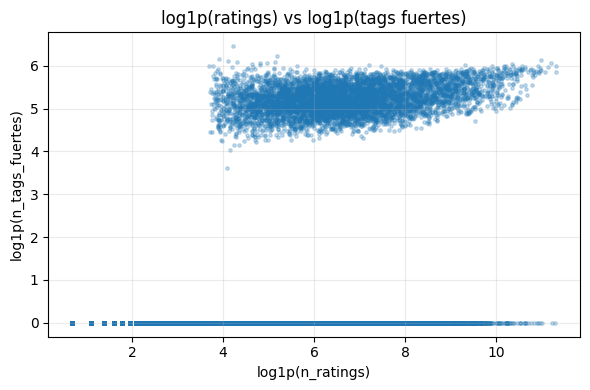

In [61]:
# usa objetos que ya tienes: movie_stats (movieId, n, mean_rt) y strong (movieId, n_strong)

sig_corr = (movie_stats.select(["movieId","n"])
            .rename({"n":"n_ratings"})
            .join(strong.rename({"n_strong":"n_tags_strong"}), on="movieId", how="left")
            .fill_null(0))

# Pearson sobre log1p (estable y barato)
nr = sig_corr["n_ratings"].to_numpy()
nt = sig_corr["n_tags_strong"].to_numpy()
r = np.corrcoef(np.log1p(nr), np.log1p(nt))[0,1]
print(f"corr( log1p(n_ratings), log1p(n_tags_fuertes) ) = {r:.3f}")

plt.figure(figsize=(6,4))
plt.scatter(np.log1p(nr), np.log1p(nt), s=6, alpha=.25)
plt.title("log1p(ratings) vs log1p(tags fuertes)")
plt.xlabel("log1p(n_ratings)"); plt.ylabel("log1p(n_tags_fuertes)")
plt.grid(alpha=.25); plt.tight_layout(); plt.show()


### Ratings vs. Tags fuertes — resumen

**Figura:** `log1p(n_ratings)` (X) vs. `log1p(n_tags_fuertes)` (Y) — **Pearson r = 0.651**.

**Lecturas clave**
- **Consistencia moderada–alta:** más votos ↔ más tags fuertes; señales alineadas pero no redundantes.
- **Masa principal:** `Y≈4.5–6.0` ⇒ ~**90–400** tags fuertes (coherente con el histograma).
- **Fila Y≈0:** títulos **sin semántica** (0 tags fuertes), típicamente con pocos ratings ⇒ requieren visual/fallback.

**Implicaciones**
- Genome es útil para **auditar** la similitud visual donde hay interés (más ratings).
- **No sustituye** al visual: hay películas con votos pero poca semántica y viceversa.
- Sesgos esperables: popularidad reciente y géneros grandes tienden a la parte alta.

**Recomendaciones**
- Reportar **Spearman** y una versión **sin ceros** (robustez).
- **Estratificar** por **década** y **género**.
- Etiquetar `Y=0` como **“sin semántica”** y **priorizar backfill** o fallback bayesiano.

**En una línea**
> Existe una correlación positiva (**r=0.651**) entre popularidad y densidad semántica: colaborativa y genome se refuerzan, pero **no son intercambiables**; el **modelo visual** sigue siendo clave para cubrir vacíos semánticos.


In [64]:
# usa sig_corr del bloque anterior (movieId, n_ratings, n_tags_strong)
x = np.log1p(sig_corr["n_ratings"].to_numpy())
y = np.log1p(sig_corr["n_tags_strong"].to_numpy())

# ranks (aprox.; ignora empates finos)
rx = np.argsort(np.argsort(x))
ry = np.argsort(np.argsort(y))
rho = np.corrcoef(rx, ry)[0,1]
print(f"Spearman (aprox): ρ = {rho:.3f}")

Spearman (aprox): ρ = 0.259


hay alineación global (suben juntos en promedio), pero el orden relativo entre películas varía mucho → muchas inversiones de orden.

Data y los poster

In [73]:
# Películas train con poster descargable
train_with_poster = movies_train.join(
    links.select(["movieId","tmdbId"]).filter(pl.col("tmdbId").is_not_null()),
    on="movieId", how="inner"
)
print(f"Películas train con poster: {train_with_poster.height}/{movies_train.height}")

# ¿Qué géneros tienen MENOS cobertura de posters?
cov_by_genre = (
    train_with_poster.select(["movieId","genres"])
    .with_columns(pl.col("genres").str.split("|").alias("genre"))
    .explode("genre")
    .group_by("genre").agg(pl.len().alias("n_with_poster"))
    .join(
        movies_train.select(["genres"])
        .with_columns(pl.col("genres").str.split("|").alias("genre"))
        .explode("genre")
        .group_by("genre").agg(pl.len().alias("n_total")),
        on="genre", how="left"
    )
    .with_columns((pl.col("n_with_poster")/pl.col("n_total")).alias("coverage"))
    .sort("coverage")
)
print(cov_by_genre)

Películas train con poster: 6615/6819
shape: (20, 4)
┌───────────┬───────────────┬─────────┬──────────┐
│ genre     ┆ n_with_poster ┆ n_total ┆ coverage │
│ ---       ┆ ---           ┆ ---     ┆ ---      │
│ str       ┆ u32           ┆ u32     ┆ f64      │
╞═══════════╪═══════════════╪═════════╪══════════╡
│ Animation ┆ 370           ┆ 421     ┆ 0.87886  │
│ Sci-Fi    ┆ 623           ┆ 668     ┆ 0.932635 │
│ Fantasy   ┆ 526           ┆ 554     ┆ 0.949458 │
│ Adventure ┆ 851           ┆ 895     ┆ 0.950838 │
│ Children  ┆ 446           ┆ 468     ┆ 0.952991 │
│ …         ┆ …             ┆ …       ┆ …        │
│ Western   ┆ 110           ┆ 112     ┆ 0.982143 │
│ Romance   ┆ 1120          ┆ 1138    ┆ 0.984183 │
│ War       ┆ 248           ┆ 251     ┆ 0.988048 │
│ IMAX      ┆ 105           ┆ 106     ┆ 0.990566 │
│ Film-Noir ┆ 67            ┆ 67      ┆ 1.0      │
└───────────┴───────────────┴─────────┴──────────┘


**Cobertura de póster (train):** 97%.  
**Brechas:** concentradas en *Animation / Children / Sci-Fi / Fantasy* (alias/TV/OVA).  
**Acción:** backfill dirigido con **imdbId** o **título+año**; **fallback** para recomendación (**genome → popularidad**) para mantener la calidad en esos géneros.

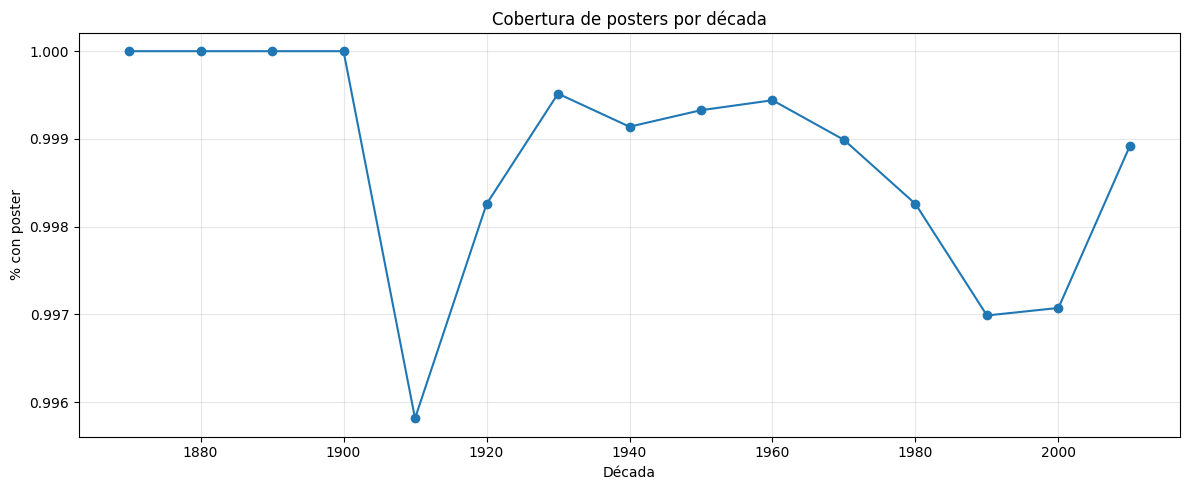

In [76]:
# Décadas con mejor/peor cobertura de posters
movies_with_poster = movies.join(
    links.select(["movieId","tmdbId"]).filter(pl.col("tmdbId").is_not_null()),
    on="movieId", how="inner"
).with_columns(
    pl.col("title").str.extract(r"\((\d{4})\)$").cast(pl.Int32).alias("year")
).drop_nulls("year").with_columns(
    ((pl.col("year")/10).floor()*10).cast(pl.Int32).alias("decade")
)

decade_coverage = (
    movies_with_poster.group_by("decade").agg(pl.len().alias("n_with_poster"))
    .join(
        movies.with_columns(
            pl.col("title").str.extract(r"\((\d{4})\)$").cast(pl.Int32).alias("year")
        ).drop_nulls("year").with_columns(
            ((pl.col("year")/10).floor()*10).cast(pl.Int32).alias("decade")
        ).group_by("decade").agg(pl.len().alias("n_total")),
        on="decade", how="left"
    )
    .with_columns((pl.col("n_with_poster")/pl.col("n_total")).alias("coverage"))
    .sort("decade")
)

plt.figure(figsize=(12,5))
plt.plot(decade_coverage["decade"], decade_coverage["coverage"], marker="o")
plt.title("Cobertura de posters por década")
plt.xlabel("Década"); plt.ylabel("% con poster"); plt.grid(alpha=.3)
plt.tight_layout(); plt.show()

In [31]:
for enc in ["utf-8", "utf-8-sig", "cp1252", "latin-1"]:
    try:
        df = pd.read_csv(CSV_PATH, encoding=enc, engine="python")
        print(f"CSV leído con encoding: {enc}")
        break
    except UnicodeDecodeError:
        continue
else:
    # Último recurso: reemplaza bytes inválidos
    df = pd.read_csv(CSV_PATH, encoding="utf-8", encoding_errors="replace", engine="python")
    print("CSV leído con utf-8 (caracteres inválidos reemplazados)")

# 2) Normaliza nombres de columnas
df.columns = df.columns.str.replace("\ufeff", "", regex=True).str.strip()

# 3) Asegura que exista la columna imdbId
if "imdbId" not in df.columns:
    # Por si viniera con otro nombre
    for alt in ["imdb_id", "imdbID", "imdb Id", "Imdb Id", "ImdbID"]:
        if alt in df.columns:
            df = df.rename(columns={alt: "imdbId"})
            break
    if "imdbId" not in df.columns:
        raise KeyError(f"No encuentro la columna 'imdbId'. Columnas: {df.columns.tolist()}")

# 4) Limpia el imdbId a solo dígitos
df["imdbId"] = (
    df["imdbId"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
)
df = df.dropna(subset=["imdbId"]).reset_index(drop=True)

# 5) Detecta cómo se llaman los archivos en la carpeta (con o sin 'tt')
filenames = set(os.listdir(IMG_DIR))
use_tt_prefix = any(name.startswith("tt") for name in filenames)

# 6) Genera el nombre de archivo correcto
if use_tt_prefix:
    df["poster_path"] = "tt" + df["imdbId"] + ".jpg"
else:
    df["poster_path"] = df["imdbId"] + ".jpg"

# 7) Filtra por los que realmente existen sin recorrer todo el FS
df = df[df["poster_path"].isin(filenames)].copy()
df["poster_fullpath"] = df["poster_path"].map(lambda x: os.path.join(IMG_DIR, x))
df = df.reset_index(drop=True)

print(f"Total de películas con imagen disponible: {len(df)}")

CSV leído con encoding: latin-1
Total de películas con imagen disponible: 1018


In [43]:
def quick_img_metrics(path, target_size=128):
    try:
        with Image.open(path).convert("RGB") as im:
            w, h = im.size
            im = im.resize((target_size, target_size))
            hsv = np.array(im.convert("HSV")).astype(np.float32)

            # Canales HSV normalizados
            v = hsv[...,2] / 255.0  # brillo
            s = hsv[...,1] / 255.0  # saturación

            # Calcular métricas promedio
            brightness = v.mean()
            saturation = s.mean()

            # Entropía tonal simple sobre brillo
            hist = np.histogram(v, bins=32, range=(0,1))[0]
            p = hist / (hist.sum() + 1e-9)
            ent = -(p * np.log(p + 1e-9)).sum()

            # Aspect ratio y tamaño
            aspect = w / h
            size_kb = os.path.getsize(path) / 1024.0

            return brightness, saturation, ent, aspect, size_kb
    except Exception as e:
        # devuelve NaN si no puede abrir o procesar la imagen
        return np.nan, np.nan, np.nan, np.nan, np.nan

In [46]:
N_SAMPLES = 800  # ajusta según potencia (500–1000 es ideal)
sample_df = df.sample(N_SAMPLES, random_state=42).copy()

records = []
for p in tqdm(sample_df["poster_fullpath"], desc="Analizando imágenes"):
    brightness, saturation, ent, aspect, size_kb = quick_img_metrics(p)
    records.append((brightness, saturation, ent, aspect, size_kb))

eda = pd.DataFrame(records, columns=["brightness","saturation","entropy","aspect","size_kb"])
sample_df = pd.concat([sample_df, eda], axis=1)

Analizando imágenes: 100%|██████████| 800/800 [00:03<00:00, 230.77it/s]


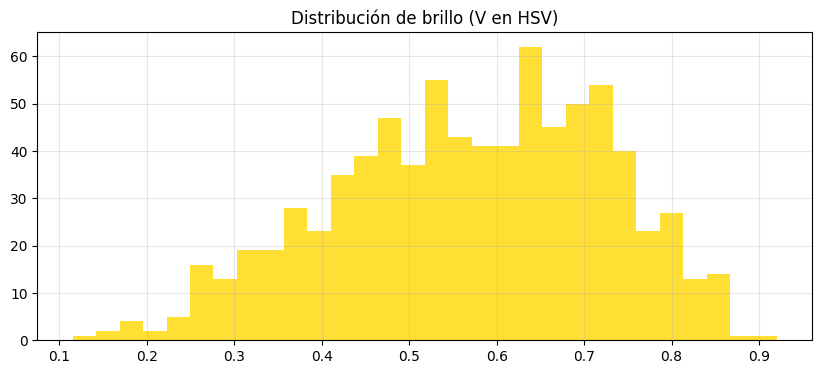

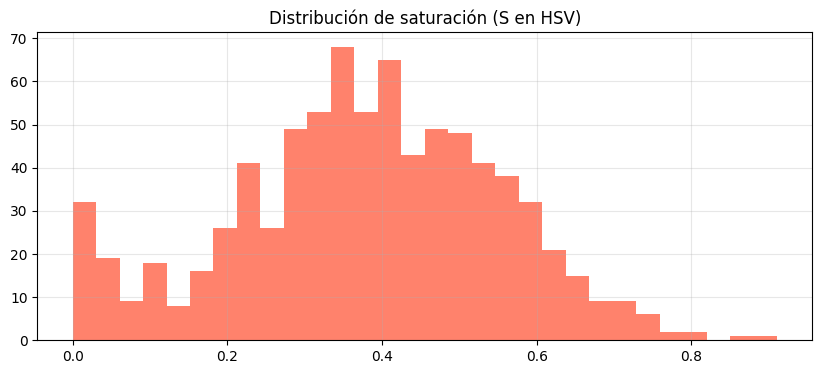

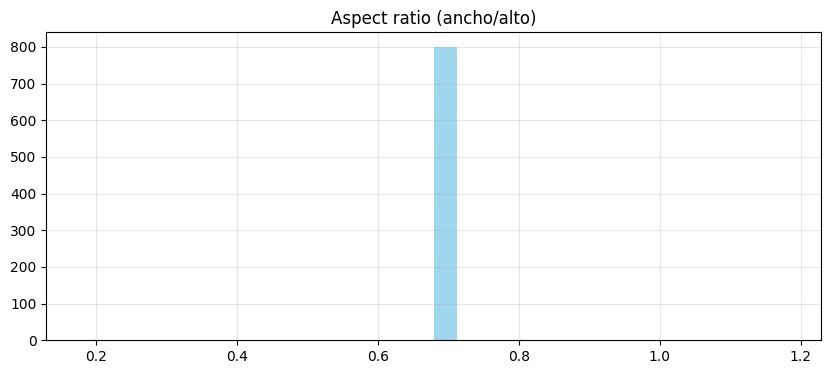

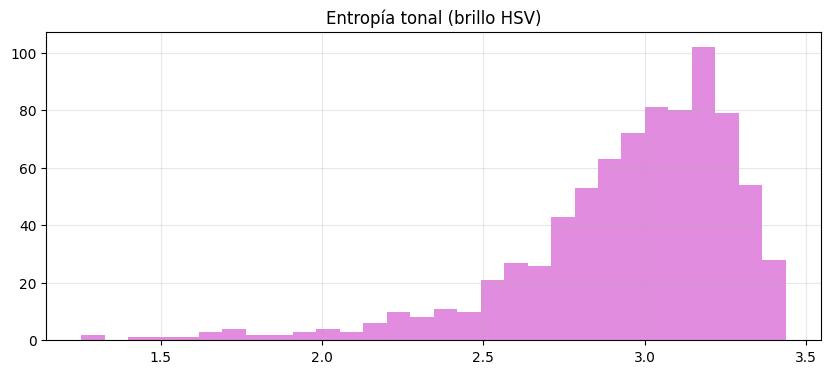

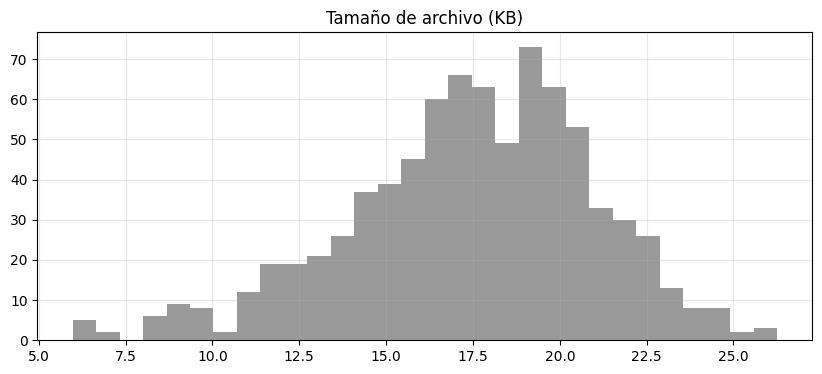

In [49]:
for col, color, title in [
    ("brightness","gold","Distribución de brillo (V en HSV)"),
    ("saturation","tomato","Distribución de saturación (S en HSV)"),
    ("aspect","skyblue","Aspect ratio (ancho/alto)"),
    ("entropy","orchid","Entropía tonal (brillo HSV)"),
    ("size_kb","gray","Tamaño de archivo (KB)")
]:
    plt.figure(figsize=(10,4))
    plt.hist(sample_df[col].dropna(), bins=30, color=color, alpha=0.8)
    plt.title(title)
    plt.grid(alpha=.3)
    plt.show()

## ¿Qué me dice cada histograma (y qué hago con eso)?

**1) Brillo (V en HSV) — centrado ~0.55–0.75**
- **Lectura:** mayoría de pósters son medio-claros; pocos muy oscuros (<0.3) o muy brillantes (>0.85).
- **Implicación:** sin normalizar, la similitud se puede sesgar por “luminosidad”.
- **Acción:** escalar V por imagen (p.ej., *per-image standardization* o CLAHE) antes de extraer features; reportar resultados estratificados por cuartiles de V.

**2) Saturación (S en HSV) — pico ~0.3–0.45, cola a la derecha**
- **Lectura:** tendencia a colores poco saturados; hay una cola de pósters “vivos” (S>0.6).
- **Implicación:** pósters muy saturados tenderán a agruparse entre sí aunque el contenido difiera.
- **Acción:** incluir features “color-invariant” (bordes, textura) y/o normalizar S por imagen; probar distancia compuesta (α·color + (1−α)·textura).

**3) Aspect ratio (w/h) — muy concentrado ~0.7**
- **Lectura:** formato casi constante (estilo póster vertical).
- **Implicación:** útil como control de calidad: cualquier valor muy fuera de 0.7±0.05 sugiere corrupción/crop raro.
- **Acción:** filtrar/outlierizar `aspect ∉ [0.6, 0.8]` o **pad**/resize consistente antes del feature extractor.

**4) Entropía tonal (sobre V) — moda ~2.8–3.2**
- **Lectura:** la mayoría tiene buena variación de luminancia; pocos extremadamente “planos” (<2.0).
- **Implicación:** entropía baja puede indicar compresión fuerte, póster minimalista o imagen defectuosa.
- **Acción:** marcar `entropy < 2.0` para revisión; ponderar menos el canal V cuando la entropía sea muy baja.

**5) Tamaño de archivo (KB) — 15–22 KB (pico), colas a 7–25 KB**
- **Lectura:** compresión relativamente homogénea; muy pequeños (<10 KB) pueden perder detalle.
- **Implicación:** riesgo de *artefactos JPEG* que afecten bordes/texture.
- **Acción:** re-encode/resize mínimo común (p.ej., lado mayor fijo) o descartar los extremos si afectan el extractor.

---

## Checks rápidos que sí valen la pena
- **Correlar** `brightness/saturation/entropy` con **género y década** → separa “estilo temporal” de contenido.
- **Cruzar** `entropy` vs. **#tags fuertes** → imágenes pobres suelen tener menor densidad semántica.
- **Outliers**: listar top-N por `size_kb` bajo, `entropy` bajo y `aspect` fuera de rango → posible limpieza.

## Resumen accionable (1 línea)
> Normaliza color/luminosidad por imagen, controla outliers de aspecto/entropía/tamaño y combina features de color + textura para evitar que brillo/saturación dominen la similitud visual.


In [67]:
# LIMPIEZA PREVIA DE RUTAS
# Asegura que todas las rutas existan y sean strings válidos
sample_df = sample_df.dropna(subset=["poster_fullpath"]).copy()
sample_df = sample_df[
    sample_df["poster_fullpath"].apply(lambda x: isinstance(x, str) and os.path.exists(x))
].reset_index(drop=True)

print(f"Imágenes válidas para procesar: {len(sample_df)}")

# EXTRACCIÓN DE FEATURES VISUALES
rows = []

for p in tqdm(sample_df["poster_fullpath"], desc="Extrayendo features"):
    if not isinstance(p, str) or not os.path.exists(p):
        continue  # ignora entradas inválidas

    f = img_features(p)
    if f is not None:
        f["poster_fullpath"] = p  # guarda ruta por si luego la quieres unir
        rows.append(f)

feat_df = pd.DataFrame(rows)
print("Features shape:", feat_df.shape)

# GUARDADO DE RESULTADOS
try:
    feat_df.to_parquet("poster_features.parquet", index=False)
except Exception as e:
    print(f"Advertencia al guardar Parquet: {e}")

feat_df.to_csv("poster_features.csv", index=False)
print("Features guardadas en: poster_features.csv y poster_features.parquet")


Imágenes válidas para procesar: 800
Extrayendo features: 100%|██████████| 800/800 [00:02<00:00, 360.98it/s]
Features shape: (800, 14)
Features guardadas en: poster_features.csv y poster_features.parquet


In [70]:
dups = (feat_df.groupby("phash")
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False))
dups.head(10)

,phash,count
255,ab9ed421df04be60,3
347,baec968fc1604c7a,2
340,ba294ba6e46c8cd9,2
707,f0cb6496b3f310cc,2
697,ef8db172cc1e30c1,2
314,b3dc6ce3a14e9a30,2
307,b29dc82267dc3966,2
118,94ace3d09d856b4d,2
508,ceaa33c7cc906e91,2
751,fbc43b2d0cb36c82,2


In [73]:
sample_feat = sample_df[["poster_fullpath","Genre"]].merge(
    feat_df, left_on="poster_fullpath", right_on="poster_fullpath", how="inner"
)

summary = (sample_feat.groupby("Genre")[["v_mean","s_mean","entropy","edge_density"]]
           .agg(["mean","std","count"]).round(3))
summary
summary.to_csv("eda_visual_summary_by_genre.csv")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=029548c5-55f1-497c-86dd-4805d0ca0d3d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>